<a href="https://colab.research.google.com/github/springboardmentor789r/AgriYield/blob/Intern_MN/Times_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/crop_yield_dataset.csv')

In [2]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
display(df.head())

,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
Date,,,,,,,,,,,
2014-01-01,Wheat,Peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
2014-01-01,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2014-01-01,Rice,Peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
2014-01-01,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
2014-01-01,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667


In [3]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])
df_resampled = numerical_df.resample('D').mean()
df_resampled = df_resampled.ffill()
display(df_resampled.head())

,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
Date,,,,,,,,,
2014-01-01,6.275,15.994309,79.994742,8.163837,64.55,51.60,40.50,37.073799,35.920833
2014-01-02,6.575,15.639907,79.998234,9.669001,67.00,54.05,43.15,34.636737,32.750000
2014-01-03,6.450,15.156596,79.028168,11.052915,66.50,53.30,42.35,22.107670,41.579167
2014-01-04,6.950,15.026332,79.479529,10.162655,68.70,55.80,44.75,28.197627,40.587500
2014-01-05,6.400,13.828252,80.000000,10.523809,68.45,55.65,45.00,26.062550,51.362500


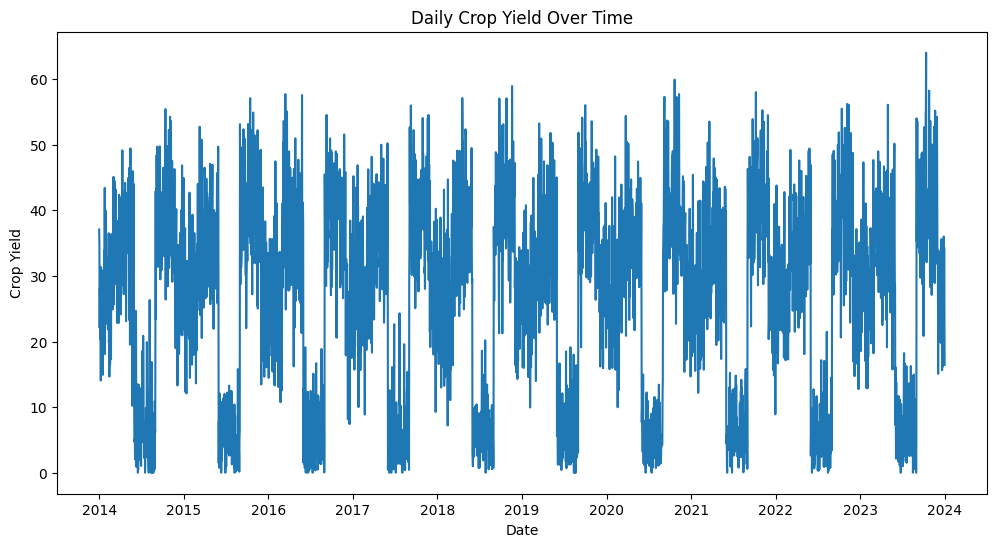

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['Crop_Yield'])
plt.title('Daily Crop Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Crop Yield')
plt.show()

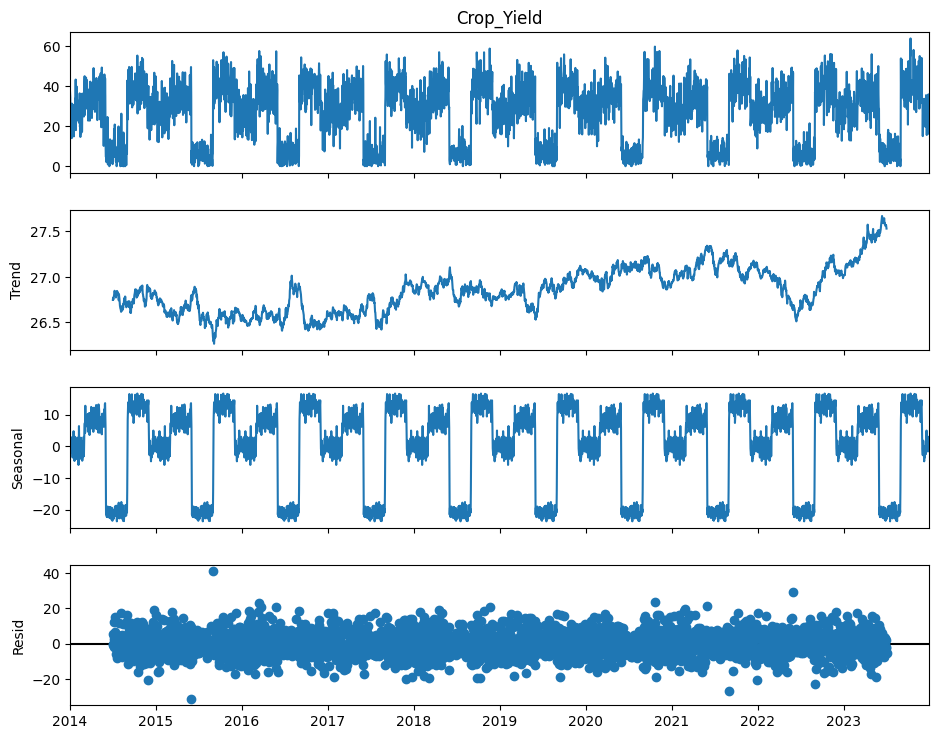

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_resampled['Crop_Yield'], model='additive', period=365)

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the 'Crop_Yield' column
adf_test = adfuller(df_resampled['Crop_Yield'])

# Print the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Number of lags used: %i' % adf_test[2])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Check for stationarity based on p-value and critical values
if adf_test[1] <= 0.05:
    print('\nConclusion: The time series is likely stationary (p-value <= 0.05).')
else:
    print('\nConclusion: The time series is likely non-stationary (p-value > 0.05).')

ADF Statistic: -6.236677
p-value: 0.000000
Number of lags used: 11
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

Conclusion: The time series is likely stationary (p-value <= 0.05).


In [7]:
print("Based on the Augmented Dickey-Fuller test, the time series for 'Crop_Yield' is stationary (p-value < 0.05).")
print("The decomposition plot also clearly shows a strong yearly seasonality.")
print("Therefore, a Seasonal Autoregressive Integrated Moving Average (SARIMA) model is a suitable choice for forecasting this time series as it can handle both stationarity and seasonality.")

Based on the Augmented Dickey-Fuller test, the time series for 'Crop_Yield' is stationary (p-value < 0.05).
The decomposition plot also clearly shows a strong yearly seasonality.
Therefore, a Seasonal Autoregressive Integrated Moving Average (SARIMA) model is a suitable choice for forecasting this time series as it can handle both stationarity and seasonality.


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Instantiate SARIMAX model with initial orders (p=1, d=0, q=1) and seasonal orders (P=0, D=0, Q=0, S=365)
# Based on the ADF test (stationary, d=0) and decomposition (yearly seasonality, S=365)
# Non-seasonal order (p, d, q): (1, 0, 1) is a common starting point for potentially autoregressive and moving average components in a stationary series.
# Seasonal order (P, D, Q, S): (0, 0, 0, 365) initially assumes no seasonal differencing (D=0) and no seasonal AR or MA components (P=0, Q=0), focusing only on the seasonal period (S=365).
model = SARIMAX(df_resampled['Crop_Yield'], order=(1, 0, 1), seasonal_order=(0, 0, 0, 365))

# Fit the SARIMA model to the data
fitted_model = model.fit()

# Print a summary of the fitted model
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Crop_Yield   No. Observations:                 3652
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -12789.052
Date:                Wed, 05 Nov 2025   AIC                          25584.105
Time:                        10:51:55   BIC                          25602.714
Sample:                    01-01-2014   HQIC                         25590.732
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9963      0.001    733.800      0.000       0.994       0.999
ma.L1         -0.6854      0.009    -72.531      0.000      -0.704      -0.667
sigma2        64.3969      1.055     61.021      0.0

In [9]:
# Generate future forecasts for a specified number of steps (e.g., 30 days)
forecast_steps = 30
forecast_results = fitted_model.get_forecast(steps=forecast_steps)

# Extract the predicted mean values from the forecast results
predicted_mean = forecast_results.predicted_mean

# Store the forecast results for later use
# The forecast_results object itself contains the predicted mean,
# confidence intervals, and potentially other information depending on the model.
# We can directly use forecast_results for plotting with confidence intervals.
display(predicted_mean.head())

,predicted_mean
2024-01-01,23.358830
2024-01-02,23.273317
2024-01-03,23.188118
2024-01-04,23.103230
2024-01-05,23.018653


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get predictions on the training data
y_train_pred = fitted_model.predict(start=df_resampled.index[0], end=df_resampled.index[-1])

# Calculate evaluation metrics
mae_train = mean_absolute_error(df_resampled['Crop_Yield'], y_train_pred)
mse_train = mean_squared_error(df_resampled['Crop_Yield'], y_train_pred)
r2_train = r2_score(df_resampled['Crop_Yield'], y_train_pred)

# Print the evaluation metrics
print(f'Training Mean Absolute Error (MAE): {mae_train:.2f}')
print(f'Training Mean Squared Error (MSE): {mse_train:.2f}')
print(f'Training R-squared (R2): {r2_train:.2f}')

Training Mean Absolute Error (MAE): 6.06
Training Mean Squared Error (MSE): 64.75
Training R-squared (R2): 0.70


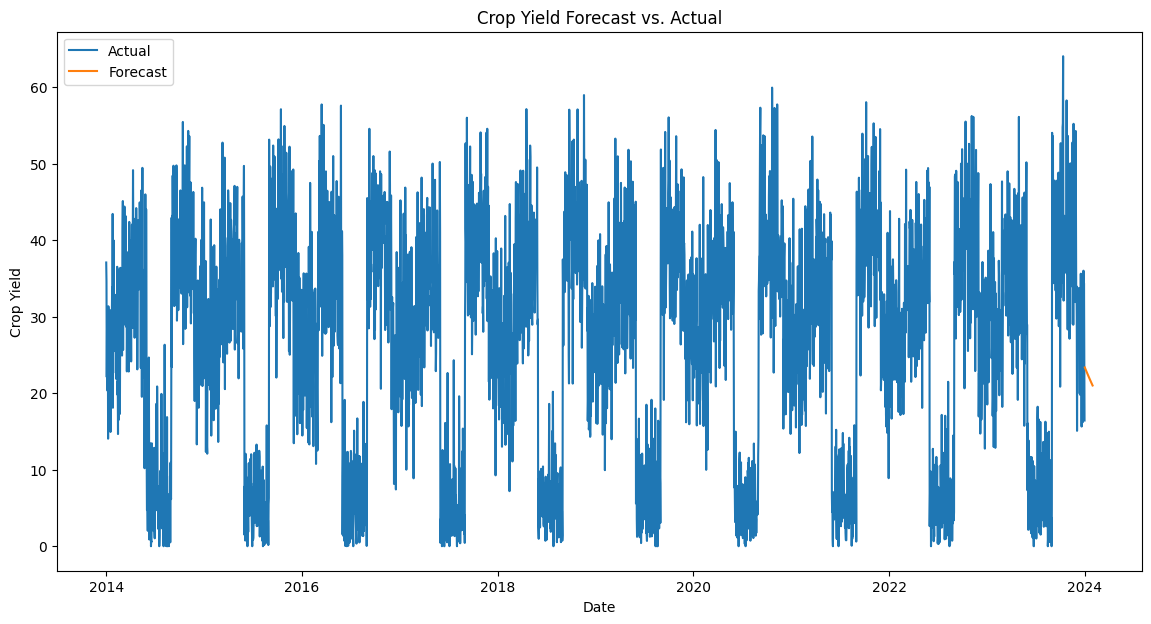

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(df_resampled.index, df_resampled['Crop_Yield'], label='Actual')
plt.plot(predicted_mean.index, predicted_mean, label='Forecast')
plt.title('Crop Yield Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Crop Yield')
plt.legend()
plt.show()